In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark import SparkConf
import os
import databricks.koalas as ks

In [3]:
#pip install koalas

#### Enable Arrow-based columnar data transfer

In [ ]:
#spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

In [2]:
conf = SparkConf().setAppName("DanApp").setMaster("spark://172.25.0.101:7077")
sc = SparkContext(conf=conf)

In [3]:
spark = SparkSession.builder \
    .master("spark://172.25.0.101:7077") \
    .appName("DanApp") \
    .getOrCreate()

In [4]:
spark.getActiveSession()

In [19]:
#for root, dirs, files in os.walk("."):
#    for filename in files:
#        print(filename)

## Describing Dataset

In [5]:
os.getcwd()

'/home/jovyan/spark'

In [7]:
#Spark Dataframe

skdf_mig_italy = spark.read.format("csv").option("header", "true").load("/home/jovyan/spark/MIG_ITALY.csv")

In [8]:
print(type(skdf_mig_italy))

<class 'pyspark.sql.dataframe.DataFrame'>


In [9]:
skdf_mig_italy.show(2)

+---+----------------------------+---+--------------------+---+------+---+---------+----+----+-----+----------+-----+
|CO2|Country of birth/nationality|VAR|            Variable|GEN|Gender|COU|  Country| YEA|Year|Value|Flag Codes|Flags|
+---+----------------------------+---+--------------------+---+------+---+---------+----+----+-----+----------+-----+
|ITA|                       Italy|B11|Inflows of foreig...|TOT| Total|AUS|Australia|2000|2000|  299|      null| null|
|ITA|                       Italy|B11|Inflows of foreig...|TOT| Total|AUS|Australia|2001|2001|  400|      null| null|
+---+----------------------------+---+--------------------+---+------+---+---------+----+----+-----+----------+-----+
only showing top 2 rows



In [10]:
skdf_mig_italy.dtypes

[('CO2', 'string'),
 ('Country of birth/nationality', 'string'),
 ('VAR', 'string'),
 ('Variable', 'string'),
 ('GEN', 'string'),
 ('Gender', 'string'),
 ('COU', 'string'),
 ('Country', 'string'),
 ('YEA', 'string'),
 ('Year', 'string'),
 ('Value', 'string'),
 ('Flag Codes', 'string'),
 ('Flags', 'string')]

### Koala

In [11]:
kdf_mig_italy = ks.read_csv("/home/jovyan/spark/MIG_ITALY.csv")

In [12]:
type(kdf_mig_italy)

databricks.koalas.frame.DataFrame

In [13]:
kdf_mig_italy.head(2)

,CO2,Country of birth/nationality,VAR,Variable,GEN,Gender,COU,Country,YEA,Year,Value,Flag Codes,Flags
0,ITA,Italy,B11,Inflows of foreign population by nationality,TOT,Total,AUS,Australia,2000,2000,299,None,None
1,ITA,Italy,B11,Inflows of foreign population by nationality,TOT,Total,AUS,Australia,2001,2001,400,None,None


In [14]:
kdf_mig_italy.info()

<class 'databricks.koalas.frame.DataFrame'>
Index: 2702 entries, 0 to 2701
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   CO2                           2702 non-null   object
 1   Country of birth/nationality  2702 non-null   object
 2   VAR                           2702 non-null   object
 3   Variable                      2702 non-null   object
 4   GEN                           2702 non-null   object
 5   Gender                        2702 non-null   object
 6   COU                           2702 non-null   object
 7   Country                       2702 non-null   object
 8   YEA                           2702 non-null   int32 
 9   Year                          2702 non-null   int32 
 10  Value                         2702 non-null   int32 
 11  Flag Codes                    0 non-null      object
 12  Flags                         0 non-null      object
dtypes: int32(3), obje

## Data Cleaning

In [15]:
# Koalas do not support pandas Categorical date type
kdf_mig_italy = kdf_mig_italy[["Country of birth/nationality","VAR","Variable","GEN","Gender","COU","Country","Year","Value"]]

### Plot

In [16]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Geo Map

#### Filtering

In [17]:
kdf_mig_italy[kdf_mig_italy["Year"]==2019].groupby("Variable").sum()

,Year,Value
Variable,,
Stock of foreign population by nationality,44418,1538353
Stock of foreign-born population by country of birth,40380,1690888
Outflows of foreign population by nationality,6057,325
Inflows of asylum seekers by nationality,58551,193
Acquisition of nationality by country of former nationality,14133,6001
Inflows of foreign population by nationality,10095,3171


In [70]:
#pip install geopandas
#pip install mapclassify
#pip install descartes

In [18]:
pddf_mig_italy_2019 = kdf_mig_italy[(kdf_mig_italy["Variable"]=="Acquisition of nationality by country of former nationality") &
                                  (kdf_mig_italy["Year"]==2019)][["Country","Year","Value"]].to_pandas()

In [19]:
type(pddf_mig_italy_2019)

pandas.core.frame.DataFrame

In [20]:
import geopandas as gpd
import pandas as pd

In [31]:
world.count()

pop_est       176
continent     176
name          176
iso_a3        176
gdp_md_est    176
geometry      176
dtype: int64

In [32]:
pddf_mig_italy_2019.count()

Country    7
Year       7
Value      7
dtype: int64

In [47]:
world_italy_2019.count()

Value    177
dtype: int64

In [38]:
#world_italy_2019.head(5)

In [49]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")]
world_italy_2019 = pd.merge(world,
                        pddf_mig_italy_2019, 
                        how="outer", # "outer"  "right"
                        left_on=["name"], 
                        right_on=["Country"])
world_italy_2019['Value'] = world_italy_2019['Value'].fillna(0)

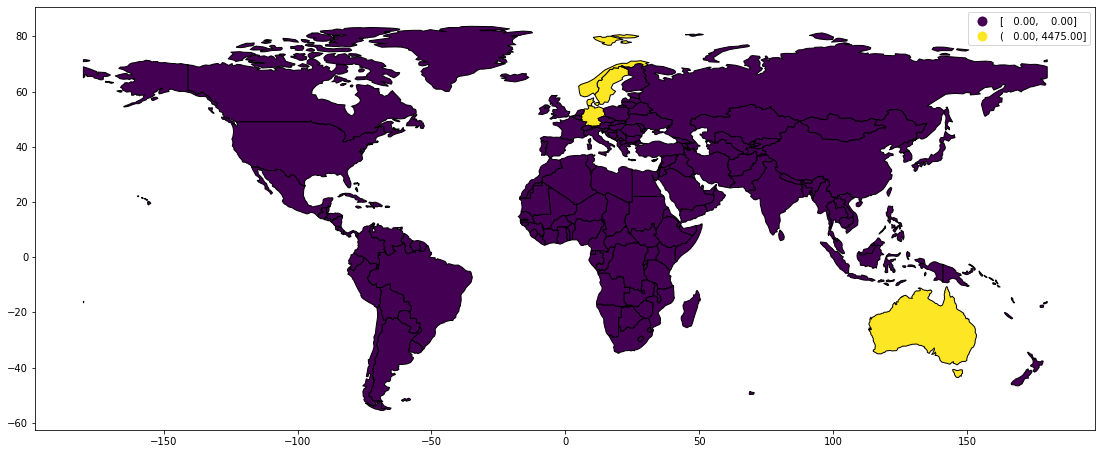

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(19,10))

world_italy_2019.plot(column='Value',
                  ax=ax, 
                  edgecolor="black",
                  cmap='OrRd',scheme='quantiles',
                  legend=True, 
                 )

In [17]:
rdd = sc.parallelize([2,3,4])
print(type(rdd))
print(rdd.take(5))

<class 'pyspark.rdd.RDD'>
[2, 3, 4]


In [52]:
print(type(sc),"\n")
print(dir(sc),"\n")
print(sc.version,"\n")
sc.getConf().getAll()

<class 'pyspark.context.SparkContext'> 

['PACKAGE_EXTENSIONS', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__getnewargs__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_accumulatorServer', '_active_spark_context', '_assert_on_driver', '_batchSize', '_callsite', '_checkpointFile', '_conf', '_dictToJavaMap', '_do_init', '_encryption_enabled', '_ensure_initialized', '_gateway', '_getJavaStorageLevel', '_initialize_context', '_javaAccumulator', '_jsc', '_jvm', '_lock', '_next_accum_id', '_pickled_broadcast_vars', '_python_includes', '_repr_html_', '_serialize_to_jvm', '_temp_dir', '_unbatched_serializer', 'accumulator', 'addFile', 'addPyFile', 'appName', 'applicationId', 'binaryFiles', 'binaryRecords', 'broadca

[('spark.app.name', 'DanApp'),
 ('spark.app.id', 'app-20210112100630-0002'),
 ('spark.master', 'spark://172.25.0.101:7077'),
 ('spark.driver.port', '37413'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.host', '99b27e601ea9'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]